# Clustering using competitive learning

In [1]:
import numpy as np
import numpy.matlib
import math
import DC_Pickle as dcp

train_scores = dcp.open_Pickle('../../data/pickles/seperate_test/eventValue.pickle')
train_scores = train_scores[:15, :]

train_data = np.ones(15)*np.nan
idx_data = []

for i in range(train_scores.shape[1]):
    if not np.isnan(train_scores[:, i]).any():
        train_data = np.vstack((train_data, train_scores[:, i]))
        idx_data.append(i)
        
train_data = numpy.delete(train_data, (0), axis=0) # delete the first row including nan
train_data = train_data.T

[n,m]  = np.shape(train_data)               # dimension and number of training data

eta    = 0.05                               # learning rate
winit  = 1                                  # initialise weight

tmax   = 40000                              # max learning iteration
clusters = 10                               # number of cluster

print(" - Dimension: {0}\n - Individuals: {1}".format(n, m))

## function for clustering with cost function return
def get_Cost(clusters_num, train):
    costs = []
    centroids = np.zeros((clusters_num, n, 10), dtype=float)
    for iter_i in range(10):
        W = winit * np.random.rand(clusters_num,n)        # Weight matrix (rows = output neurons, cols = input neurons)
        normW = np.sqrt(np.diag(W.dot(W.T)))
        normW = normW.reshape(clusters_num,-1)            # reshape normW into a numpy 2d array
        W = W / normW                               # normalise using numpy broadcasting

        normTrain = np.sqrt(np.diag(np.dot(train.T, train)))
        normTrain = normTrain.reshape(m, -1)
        train = train/normTrain.T

        counter = np.zeros((1,clusters_num))              # counter for the winner neurons
        wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time
        alpha = 0.999

        yl = int(round(clusters_num/5))                   # counter for the rows of the subplot
        if clusters_num % 5 != 0:
            yl += 1

        for t in range(1,tmax):
            i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
            x = train[:,i]                          # pick a training instance using the random index

            h = W.dot(x)/clusters_num                     # get output firing
            h = h.reshape((h.shape[0],-1))          # reshape h into a numpy 2d array

            xi = np.random.rand(clusters_num,1) / 200
            k = np.argmax(h+xi)                     # get the index of the firing neuron

            counter[0,k] += 1                       # increment counter for winner neuron

            dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron

            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)

            W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

            if wCount[0, t] < 0.0001: # if it learns sufficiently with learning rate below 0.0001
                break

        ##########################################
        ## save means of clusters into the 3X3 centroids matrix
        centroids[:, :, iter_i] = W

        ##########################################
        ## get indices of clusters for each data
        cluster_idx = []
        for data in range(m): # check all data
            min_vals = []
            for weight in range(clusters_num): # compare all clusters for a data
                diff = W[weight, :] - train[:, data] # get difference between data and clusters
                min_vals.append(sum(np.square(diff))) # get square distance

            min_idx = np.argmin(min_vals) # get cluster index which has minimum distance
            cluster_idx.append(min_idx) # assign the index to the cluster_idx array


        # assign True and False if data belongs to specific cluster.
        for i in range(clusters_num):
            cluster_map = np.array(cluster_idx) == i

            # make matrix of True and False for mapping
            cluster = cluster_map
            for j in range(14):
                cluster = np.vstack((cluster, cluster_map))
            #print(np.shape(train[cluster].reshape(n, -1)))

            for k in range(clusters_num):
                clt = "cluster{0}".format(i)
                globals()[clt]=train[cluster].reshape(n, -1)
            #print("cluster{0}: ".format(i), np.shape(eval("cluster{0}".format(i))))

        ##########################################
        ## Get average cost function of 10 iterations
        diff_sum = [] # all differences of clusters
        for c in range(clusters_num):
            diff_vals = [] # difference for one cluster
            clt = "cluster{0}".format(c)
            [n2, m2] = np.shape(eval(clt))
            for data in range(m2):
                diff = np.square(eval(clt)[:, data] - W[c, :])
                diff_vals.append(np.sum(diff))

            diff_sum.append(np.sum(diff_vals))

        costs.append(np.sum(diff_sum))

    return min(costs), centroids

 - Dimension: 15
 - Individuals: 69


# AIC & BIC & Elbow methods

In [2]:
import time
t0 = time.clock() # initial time

elbow = []
AIC = []
BIC = []
for clt in range(clusters):
    cent_matrix = "cent_matrix{0}".format(clt+1)
    [cost, cent] = get_Cost(clt+1, train_data)
    globals()[cent_matrix] = cent
    
    elbow.append(cost)
    AIC.append(cost + 2*clt)
    BIC.append(cost +  clt*math.log10(15))
    print("iteration ", clt+1)

print("\n - process terminal (Run time:{0})".format(time.clock()-t0))

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10

 - process terminal (Run time:39.573993)


In [3]:
print(np.shape(cent_matrix10))

(10, 15, 10)


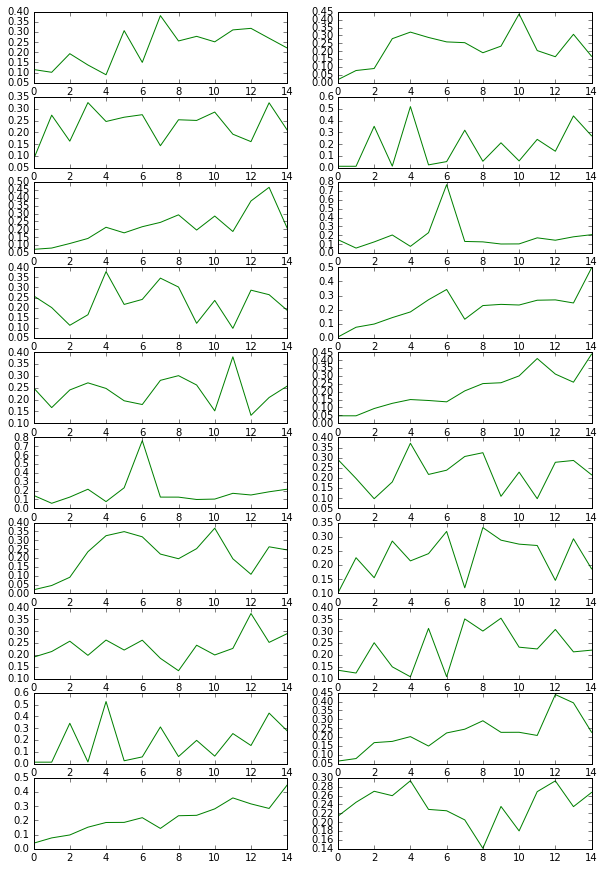

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(10, 2, figsize=(10, 15))

for jj in range(2):
    for ii in range(10):
        axes[ii, jj].plot(np.arange(15), cent_matrix10[ii, :, jj], 'g-')

### Plotting

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.add_subplot(1,1,1) 

# ax.set_yticks(np.arange(0, 20, 3), minor=True)

ax.grid(which='both')

# ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)

ax.plot(np.arange(clusters)+1, elbow, 'g-', label="Elbow")
ax.plot(np.arange(clusters)+1, AIC, 'r-', label="AIC")
ax.plot(np.arange(clusters)+1, BIC, 'b-', label="BIC")
ax.set_xlabel('k')
ax.set_ylabel('average cost function')
ax.legend()
fig.savefig('Figs/AIC_BIC.png', dpi=100)